<a href="https://colab.research.google.com/github/Muhameddemadd/Pneumonic-Chest-X-ray-Classification/blob/master/product_defect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"mohameddemadd","key":"286216a909d0f5526e2a0c599fa4ef41"}'}

In [4]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!pip install kaggle
import kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:44<00:00, 24.3MB/s]
100% 2.29G/2.29G [01:45<00:00, 23.4MB/s]


In [11]:
!unzip -q '/content/chest-xray-pneumonia.zip'


In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import datasets, models, transforms
from torch.nn import functional as F
import torch.optim as optim
from PIL import Image
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split



In [47]:

input_path ='/content/chest_xray/chest_xray'

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + '/train', data_transforms['train']),
    'test': 
    datasets.ImageFolder(input_path + '/test', data_transforms['test'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)}  

In [48]:
train_dataset = ImageFolder(input_path + '/train', data_transforms['train'])
test_dataset = ImageFolder(input_path + '/test', data_transforms['test'])

img, label = train_dataset[0]
print(img.shape,label)
print("Follwing classes are there :"+ str(len(train_dataset.classes)),train_dataset.classes)




torch.Size([3, 224, 224]) 0
Follwing classes are there :2 ['NORMAL', 'PNEUMONIA']


In [49]:
batch_size = 32
test_size = 1300
train_size = len(train_dataset) - test_size
train_dataset,test_dataset = random_split(train_dataset,[train_size,test_size])
print(f"Length of Train Data : {len(train_dataset)}")
print(f"Length of test Data : {len(test_dataset)}")

total = len(train_dataset)+len(test_dataset)
print(total)
train_len= len(train_dataset)
test_len= len(test_dataset)
print((train_len/total)*100)

Length of Train Data : 3916
Length of test Data : 1300
5216
75.07668711656443


Label: 1
torch.Size([3, 224, 224])


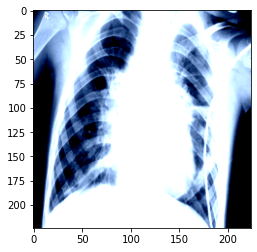

In [50]:
image, label = test_dataset[100]
print(f"Label: {label}")
plt.imshow(image.permute(1, 2, 0))
print(image.shape)
plt.show()

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [53]:
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, pin_memory = True)
val_dl = DataLoader(test_dataset, batch_size*2, pin_memory = True)

In [54]:
model = models.resnet50(pretrained=True)

model.fc = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(512, 2),
                           nn.LogSoftmax(dim=1))
model.to(device)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [55]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

In [57]:
def train_model(model, criterion, optimizer, num_epochs=3):
  
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [58]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)


Epoch 1/3
----------
train loss: 0.2716, acc: 0.8946
test loss: 0.7640, acc: 0.7404
Epoch 2/3
----------
train loss: 0.1711, acc: 0.9316
test loss: 0.5909, acc: 0.7997
Epoch 3/3
----------
train loss: 0.1512, acc: 0.9423
test loss: 0.5079, acc: 0.8189


RuntimeError: ignored